<h1>Multiclass Classification</h1>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('data/final_spotify_tracks.csv')
data.set_index(['title'], inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,POP,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,HIPHOP,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,POP,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,POP,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,POP,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


Поради тоа што артистот и врвниот жанр се текстуални променливи и не можат да се користат како такви, ќе ги кодирам со помош на кодерот за етикети.

In [5]:
data[['artist']] = data[['artist']].apply(LabelEncoder().fit_transform)
data[['top genre']] = data[['top genre']].apply(LabelEncoder().fit_transform)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,4,3.693075,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,58,3,44.814807,94.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,103,4,6.410236,81.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,108,4,17.680180,89.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,26,4,31.020064,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


Овој пат ќе го користам врвниот жанр како повеќекласна целна променлива.

In [6]:
X, Y = data[data.columns.drop(['top genre'])], data['top genre']

In [8]:
scaler = MinMaxScaler()
X[X.columns.drop(['artist', 'year'])] = scaler.fit_transform(X[X.columns.drop(['artist', 'year'])])

In [15]:
X = X.fillna(X.median())

Извршувам пополнување на вредностите што недостасуваат со нивната медијана.

Бидејќи податоците се од различни типови, имаме:  nominal, ordinal, interval и ration attributes, ќе дефинирам прилагодена метрика. <br>

Binary (target): is_dance_pop <br>
Nominal attributes: title, artist<br>
Ordinal attributes: year (2010 - 2020)<br>
Interval: loudness<br>
Ratio: other <br>

Прилагодената метрика ги проценува номиналните променливи така што проверува дали се исти или не, за редните променливи го користи растојанието помеѓу вредностите поделени со нивниот опсег, потоа квадратот, а за континуираните променливи ја додава квадратната разлика и на крај се враќа квадратен корен од целосната сума.

In [1]:
def custom_metric(x, y):
  score = 0
  val = (x[0]!=y[0])**2 #for artist (nominal)
  score += val
  count = 0

  for xi, yi in zip(x[1:], y[1:]):
    if count == 3:
      score += (abs((xi-yi) / 9))**2 #for year (ordinal)
    else:
      score += (xi-yi)**2
    count += 1

  return np.sqrt(score)

Дефинирање на функција која врши вкрстени предвидувања за 5-кратна валидација.

In [12]:
def cross_validation_model(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  score = cross_val_score(model, X, Y)

  return predicted, actual, score

In [16]:
X_cont = X.drop(['artist', 'year'], axis=1)

In [17]:
errors = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine',custom_metric]

for metric in metrics:
  node = []
  for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric=metric, p=3)
    if metric != metrics[-1]:
        pred_i, act_i, score_i = cross_validation_model(X_cont, Y, knn)
    else:
        pred_i, act_i, score_i = cross_validation_model(X, Y, knn)
    err = np.mean([1 if pred_i[i] != act_i[i] else 0 for i in range(len(pred_i))])
    node.append(err)
  errors.append(node)   

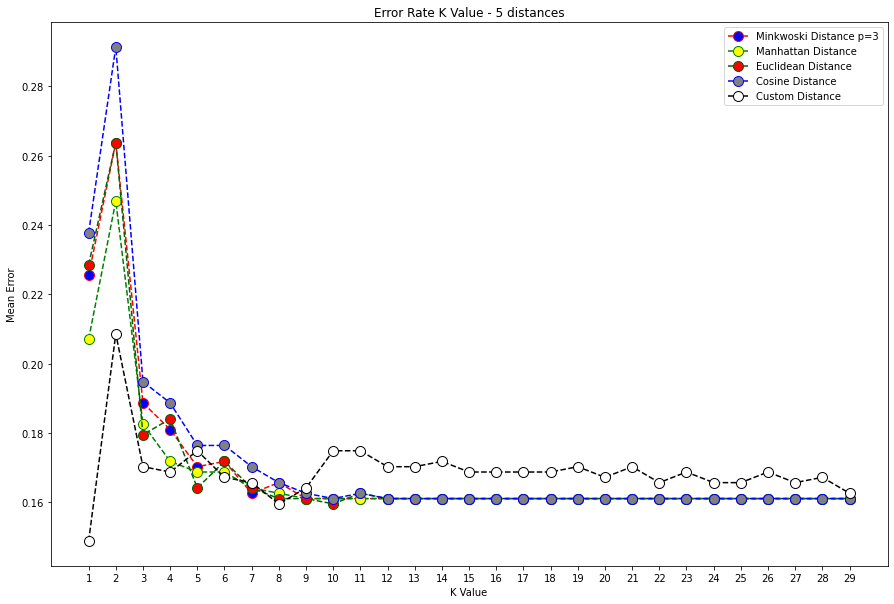

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 30), errors[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Error')
plt.legend()
plt.show()

Ќе ја користам прилагодената метрика со 1 најблизок сосед бидејќи има најдобри резултати.

In [48]:
clf = KNeighborsClassifier(n_neighbors=1, metric=custom_metric)
cv_predictions, cv_actual, cv_score = cross_validation_model(X, Y, clf)

In [49]:
print(classification_report(cv_actual, cv_predictions))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.00      0.00      0.00         1
           2       0.48      0.52      0.50        29
           3       0.55      0.45      0.49        38
           4       0.91      0.93      0.92       547
           5       0.00      0.00      0.00         6
           6       0.42      0.38      0.40        21

    accuracy                           0.85       652
   macro avg       0.42      0.42      0.42       652
weighted avg       0.84      0.85      0.85       652



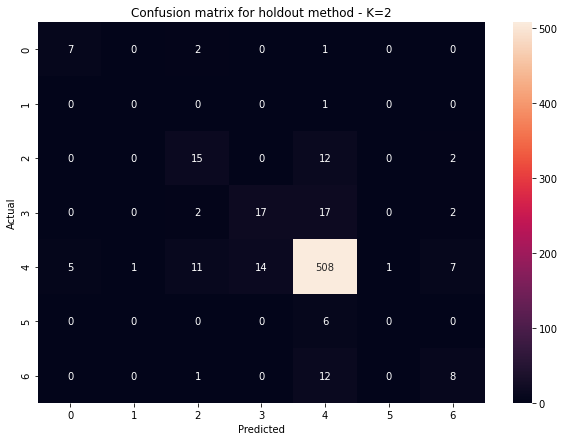

In [50]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(cv_actual, cv_predictions), annot=True, fmt='.5g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for holdout method - K=2')
plt.show()

Имајќи во предвид дека збирот на податоци е многу неурамнотежен, овие резултати всушност и не се толку лоши. <br>
KNN го класифицира поголемиот дел од најраспространетите класи како ture, додека другите помалку распространети класи се исто така класифицирани на добар начин. Има само една песна од жанрот country, но не е класифицирана како country што се очекува.

<h3>Logistic regression</h3>

Ги користам овие параметри за да ги пронајдам најдобрите за логистичка регресија, при што користам мрежно пребарување со внатрешна 5-кратна вкрстена валидација што го максимизира f1-score.

In [37]:
parameters_log_reg = {
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
}

In [42]:
grid = GridSearchCV(LogisticRegression(), param_grid=parameters_log_reg, scoring='f1_weighted', cv=5)
grid.fit(X, Y)
grid.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

In [43]:
logreg = LogisticRegression(penalty=grid.best_params_['penalty'], solver=grid.best_params_['solver'])
logistic = OneVsRestClassifier(logreg, n_jobs=-1)

-Изработка на 5-кратна вкрстена валидација

In [44]:
cv_predictions, cv_actual, cv_score = cross_validation_model(X, Y, logistic)

In [45]:
print(classification_report(cv_actual, cv_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        38
           4       0.84      1.00      0.91       547
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        21

    accuracy                           0.84       652
   macro avg       0.12      0.14      0.13       652
weighted avg       0.70      0.84      0.77       652



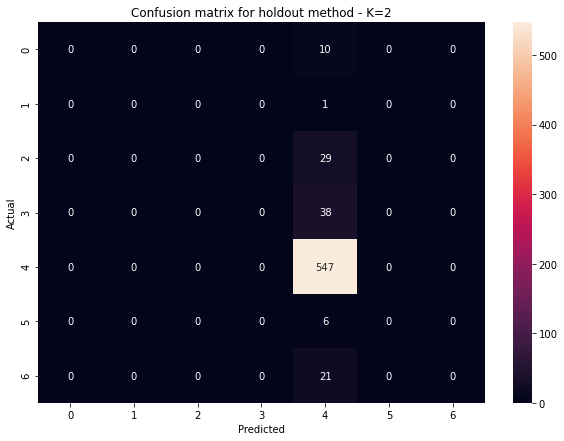

In [47]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(cv_actual, cv_predictions), annot=True, fmt='.5g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for holdout method - K=2')
plt.show()

Моделот на логистичката регресија ја предвидува само класата 4 која всушност е поп.

КNN имаше многу подобри перформанси во однос на логистичката регресија.